In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Fetching the data set and then we both split the data and normalize it

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

X_train_flat = X_train.reshape(-1, 28 * 28)
X_valid_flat = X_valid.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Defining the Layers and Activation Classes

In [2]:
class Layer_Dense:
    def __init__(self,n_inputs,n_neurons,l2_regularizer = 0):
        
        self.weights = 0.01 * np.random.randn(n_inputs,n_neurons)
        self.biases = np.zeros((1,n_neurons))

        self.l2_regularizer = l2_regularizer

        
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights) + self.biases
        
       
    def backward(self,dL_dZ):
        # Partial derivative of the Loss with respect to Weights
        self.dweights = np.dot(self.inputs.T ,dL_dZ)
        # Partial derivative of the Loss with respect to Biases
        self.dbiases = np.sum(dL_dZ,axis=0,keepdims=True)

        # Gradients of Regularization
        if self.l2_regularizer > 0:
            self.dweights += 2 * self.l2_regularizer * self.weights
            self.dbiases  += 2 * self.l2_regularizer * self.biases
        
        # Partial derivative of the Loss with respect to Inputs
        self.dinputs = np.dot(dL_dZ,self.weights.T)

# Dropout layer for prevent from overfitting
class Layer_Dropout:
    def __init__(self, dropout_rate):
        self.rate = 1 - dropout_rate

    def forward(self, inputs):
        self.inputs = inputs

        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate

        self.output = inputs * self.binary_mask

    def backward(self, dL_dZ):
        self.dinputs = dL_dZ * self.binary_mask


class Activation_ReLU:
        
    def forward(self,inputs):
        
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
        
    def backward(self,dL_dZ):

        self.dinputs = dL_dZ.copy()
        self.dinputs[self.inputs <= 0] = 0


class Activation_Softmax:
    def forward(self,inputs):

        exponent_matrix = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exponent_matrix / np.sum(exponent_matrix, axis=1, keepdims=True)

Defining Loss Functions and Optimizers

In [3]:
class Loss:
 
    def calculate(self, output, y):

        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
    def regularization_loss(self, layer):

        regularization_loss = 0

        if layer.l2_regularizer > 0:
            regularization_loss += layer.l2_regularizer * np.sum(layer.weights **2)
            regularization_loss += layer.l2_regularizer * np.sum(layer.biases  **2)

        return regularization_loss

class Loss_CategoricalCrossentropy(Loss):
    
    def forward(self, y_pred, y_true):
        
        samples = len(y_pred)

        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
    
        #If categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples),y_true]
        
        #If one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true,axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

class Activation_Softmax_Loss_CategoricalCrossentropy:
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

        
    def backward(self, dL_dZ, y_true):
        
        samples = len(dL_dZ)
        # If labels are one-hot encoded
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        self.dinputs = dL_dZ.copy()
        #Calculate the gradient
        self.dinputs[range(samples), y_true] -= 1
        #Normalize the gradient
        self.dinputs = self.dinputs / samples



class Optimizer_SGD:
    
    def __init__(self, learning_rate=1, decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    
    def update_params(self, layer):
        
        if self.momentum:
            
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            
            weight_updates = self.momentum * layer.weight_momentums -  self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        
        layer.weights += weight_updates
        layer.biases += bias_updates

    
    def post_update_params(self):
        self.iterations += 1


class Optimizer_Adam:

    def __init__(self, learning_rate = 0.001, decay = 0., epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))

    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases  += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

Some images from the dataset

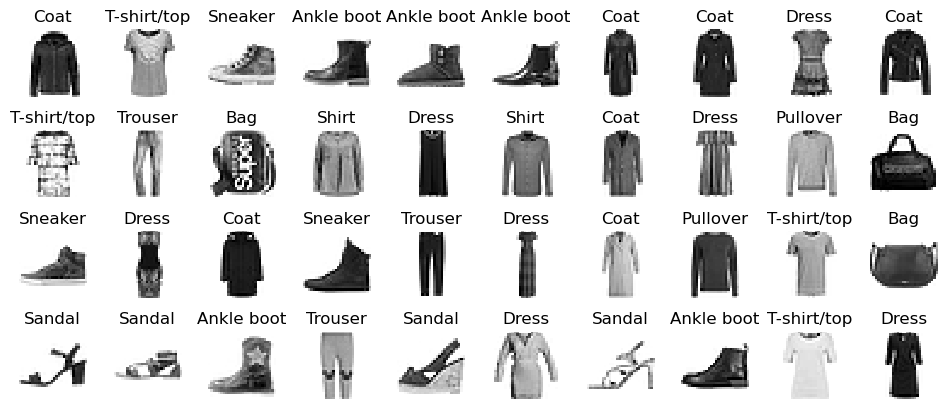

In [4]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Initializing the Model

In [8]:
# Neural Network Model

dense1 = Layer_Dense(784, 200,l2_regularizer=1e-3)

activation1 = Activation_ReLU()

dropout1 = Layer_Dropout(dropout_rate=0.3)

dense2 = Layer_Dense(200 , 100,l2_regularizer=1e-3)

activation2 = Activation_ReLU()

dropout2 = Layer_Dropout(dropout_rate=0.3)

dense3 = Layer_Dense(100, 10,l2_regularizer=1e-3)

loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
loss_activation_valid = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adam(learning_rate=0.004, decay=5e-3)

## Training the model may take some time due to vast amount of data and complexity of the model

In [9]:
for epoch in range(500):
    
    # Forward pass for training data
    dense1.forward(X_train_flat)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward(dropout1.output)
    activation2.forward(dense2.output)
    dropout2.forward(activation2.output)
    dense3.forward(dropout2.output)
    data_loss = loss_activation.forward(dense3.output, y_train)
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) + loss_activation.loss.regularization_loss(dense3)
    loss_train = data_loss + regularization_loss


    predictions_train = np.argmax(loss_activation.output, axis=1)
    if len(y_train.shape) == 2:
        y_train = np.argmax(y_train, axis=1)
    accuracy_train = np.mean(predictions_train == y_train)
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y_train)
    dense3.backward(loss_activation.dinputs)
    dropout2.backward(dense3.dinputs)
    activation2.backward(dropout2.dinputs)
    dense2.backward(activation2.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)

    #Forward pass for validation data
    dense1.forward(X_valid_flat)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    loss_valid = loss_activation_valid.forward(dense3.output, y_valid)

    predictions_validation = np.argmax(loss_activation_valid.output, axis=1)
    if len(y_train.shape) == 2:
        y_train = np.argmax(y_train, axis=1)
    accuracy_validation = np.mean(predictions_validation == y_valid)

    if not epoch % 10:
        print(f'epoch: {epoch}, ' +
              f'acc_train: {accuracy_train:.3f}, ' +
              f'loss_train: {loss_train:.3f}, ' +
              f'acc_valid: {accuracy_validation:.3f}, ' +
              f'loss_valid: {loss_valid:.3f}, ' +
               f'lr: {optimizer.current_learning_rate}')
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc_train: 0.096, loss_train: 2.320, acc_valid: 0.116, loss_valid: 2.302, lr: 0.004
epoch: 10, acc_train: 0.485, loss_train: 1.282, acc_valid: 0.574, loss_valid: 1.149, lr: 0.0038277511961722493
epoch: 20, acc_train: 0.633, loss_train: 1.037, acc_valid: 0.665, loss_valid: 0.883, lr: 0.0036529680365296807
epoch: 30, acc_train: 0.692, loss_train: 0.901, acc_valid: 0.712, loss_valid: 0.737, lr: 0.0034934497816593887
epoch: 40, acc_train: 0.755, loss_train: 0.789, acc_valid: 0.786, loss_valid: 0.616, lr: 0.0033472803347280333
epoch: 50, acc_train: 0.787, loss_train: 0.719, acc_valid: 0.804, loss_valid: 0.549, lr: 0.0032128514056224897
epoch: 60, acc_train: 0.808, loss_train: 0.669, acc_valid: 0.829, loss_valid: 0.501, lr: 0.003088803088803089
epoch: 70, acc_train: 0.818, loss_train: 0.639, acc_valid: 0.836, loss_valid: 0.471, lr: 0.0029739776951672866
epoch: 80, acc_train: 0.825, loss_train: 0.622, acc_valid: 0.839, loss_valid: 0.457, lr: 0.002867383512544803
epoch: 90, acc_train

Evaluating on Test Data

In [19]:
print("Final train accuracy:",accuracy_train)

#Testing the model with test data

dense1.forward(X_test_flat)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
loss_test = loss_activation.forward(dense3.output,y_test)
predictions_test = np.argmax(loss_activation.output, axis=1)

if len(y_test.shape) == 2:
    y_test = np.argmax(y_test,axis=1)

accuracy_test = np.mean(predictions_test == y_test)
print("Test accuracy:",accuracy_test)





Final train accuracy: 0.8860727272727272
Test accuracy: 0.8756


## Selecting 10 random images from test set and predicting using the model

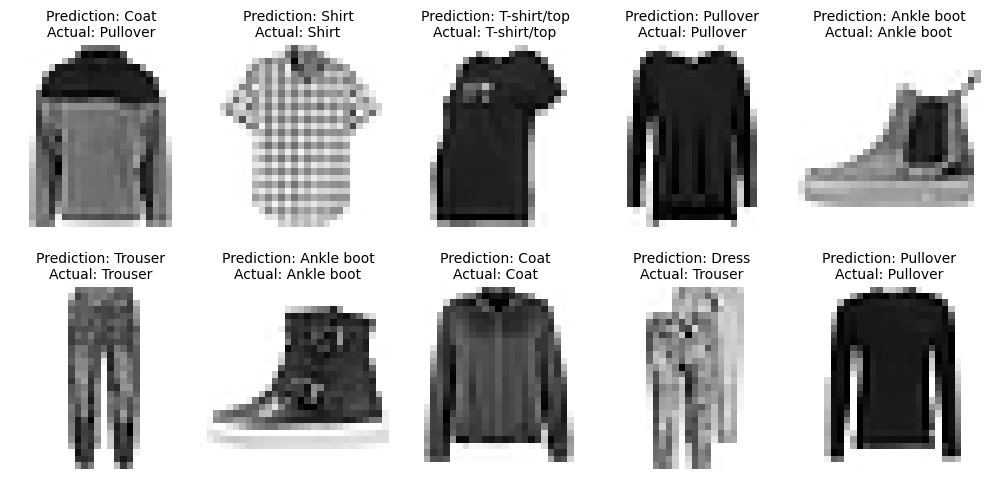

In [26]:
activation_output = Activation_Softmax()

random_indices = np.random.choice(X_test.shape[0], 10, replace=False)

plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_indices): 
    
    dense1.forward(X_test_flat[idx])
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation_output.forward(dense3.output)

    
    predictions_test = np.argmax(activation_output.output, axis=1)
    
    plt.subplot(4, 5, i + 1) 
    plt.title(f"Prediction: {class_names[predictions_test[0]]}\nActual: {class_names[y_test[idx]]}", fontsize=10)
    plt.imshow(X_test[idx], cmap="binary")
    plt.axis('off')

plt.tight_layout()
plt.show()